<a href="https://colab.research.google.com/github/LibbyFender/playground/blob/master/Baseball_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Baseball sandbox quick coding to shake off some rust. May 2019
#Import Libraries
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#2018 MLB data from RetroSheet game logs. Current as of Nov 2018    https://www.retrosheet.org/gamelogs/index.html Aditya Dua, Analyzing Baseball Statistics

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GL2018.TXT to GL2018 (2).TXT
User uploaded file "GL2018.TXT" with length 2650920 bytes


In [0]:
df = pd.read_csv('GL2018.TXT', sep=',', header=None)

In [36]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,8,51,N,NaN,NaN,NaN,PHO01,48703,216,100001000,30000320x,33,9,0,0,2,2,1,0,0,2,0,12,0,0,2,0,7,5,8,...,Ian Desmond,3,parrg001,Gerardo Parra,7,iannc001,Chris Iannetta,2,grayj003,Jon Gray,1,perad001,David Peralta,7,polla001,A.J. Pollock,8,goldp001,Paul Goldschmidt,3,lambj001,Jake Lamb,5,martk001,Ketel Marte,4,avila001,Alex Avila,2,ahmen001,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,8,53,D,NaN,NaN,NaN,ATL03,40208,208,100004000,000002033,31,6,2,0,1,5,0,0,1,6,0,11,1,0,2,0,6,6,7,...,J.P. Crawford,6,franm004,Maikel Franco,5,knapa001,Andrew Knapp,2,nolaa001,Aaron Nola,1,incie001,Ender Inciarte,8,albio001,Ozzie Albies,4,freef001,Freddie Freeman,3,markn001,Nick Markakis,9,flowt001,Tyler Flowers,2,tuckp001,Preston Tucker,7,swand001,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y
2,20180329,0,Thu,SFN,NL,1,LAN,NL,1,1,0,54,D,NaN,NaN,NaN,LOS03,53595,175,000010000,000000000,34,8,2,0,1,1,0,0,0,2,0,11,0,0,1,0,8,5,0,...,Hunter Pence,7,beltb001,Brandon Belt,3,crawb001,Brandon Crawford,6,blact002,Ty Blach,1,taylc001,Chris Taylor,8,seagc001,Corey Seager,6,puigy001,Yasiel Puig,9,herne001,Enrique Hernandez,4,bellc002,Cody Bellinger,3,kempm001,Matt Kemp,7,grany001,Yasmani Grandal,2,forsl001,Logan Forsythe,5,kersc001,Clayton Kershaw,1,NaN,Y
3,20180329,0,Thu,CHN,NL,1,MIA,NL,1,8,4,54,D,NaN,NaN,NaN,MIA02,32151,198,310100300,103000000,35,9,4,0,3,8,0,0,3,5,2,10,1,0,1,1,9,6,3,...,Addison Russell,6,heywj001,Jason Heyward,9,baezj001,Javier Baez,4,lestj001,Jon Lester,1,brinl001,Lewis Brinson,8,dietd001,Derek Dietrich,7,casts001,Starlin Castro,4,bourj002,Justin Bour,3,andeb006,Brian Anderson,5,coopg002,Garrett Cooper,9,rojam002,Miguel Rojas,6,wallc001,Chad Wallach,2,urenj001,Jose Urena,1,NaN,Y
4,20180329,0,Thu,SLN,NL,1,NYN,NL,1,4,9,51,D,NaN,NaN,NaN,NYC20,44189,181,020101000,12005001x,33,6,1,0,2,4,0,0,0,1,0,15,0,0,0,0,3,6,8,...,Yadier Molina,2,dejop001,Paul DeJong,6,wongk001,Kolten Wong,4,martc006,Carlos Martinez,1,nimmb001,Brandon Nimmo,8,cespy001,Yoenis Cespedes,7,brucj001,Jay Bruce,9,cabra002,Asdrubal Cabrera,4,frazt001,Todd Frazier,5,gonza003,Adrian Gonzalez,3,plawk001,Kevin Plawecki,2,syndn001,Noah Syndergaard,1,rosaa003,Amed Rosario,6,NaN,Y


In [37]:
df.shape

(2431, 161)

Adding Column Names from Data Dictionary

In [0]:
def rename_cols(input_df):
  input_df.rename(columns = {0:'Date', 2:'DOW', 3:'Visiting_Team', 6:'Home_Team', 9:'Runs_Visiting_Team', 10:'Runs_Home_Team', 50:'Hits_Home_Team'}, inplace=True)
  return input_df

In [39]:
df = rename_cols(df)
df.head(2)

,Date,1,DOW,Visiting_Team,4,5,Home_Team,7,8,Runs_Visiting_Team,Runs_Home_Team,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,8,51,N,NaN,NaN,NaN,PHO01,48703,216,100001000,30000320x,33,9,0,0,2,2,1,0,0,2,0,12,0,0,2,0,7,5,8,...,Ian Desmond,3,parrg001,Gerardo Parra,7,iannc001,Chris Iannetta,2,grayj003,Jon Gray,1,perad001,David Peralta,7,polla001,A.J. Pollock,8,goldp001,Paul Goldschmidt,3,lambj001,Jake Lamb,5,martk001,Ketel Marte,4,avila001,Alex Avila,2,ahmen001,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,8,53,D,NaN,NaN,NaN,ATL03,40208,208,100004000,000002033,31,6,2,0,1,5,0,0,1,6,0,11,1,0,2,0,6,6,7,...,J.P. Crawford,6,franm004,Maikel Franco,5,knapa001,Andrew Knapp,2,nolaa001,Aaron Nola,1,incie001,Ender Inciarte,8,albio001,Ozzie Albies,4,freef001,Freddie Freeman,3,markn001,Nick Markakis,9,flowt001,Tyler Flowers,2,tuckp001,Preston Tucker,7,swand001,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y


Create 2 columns to track an away win & a visitor win. This could also be a binary Home win yes no column.

In [0]:
def who_won(input_df):
  input_df['Home_Win'] = input_df['Runs_Home_Team'] >input_df['Runs_Visiting_Team']
  input_df['Away_Win']= input_df['Runs_Visiting_Team'] > input_df['Runs_Home_Team']
  return input_df

In [41]:
df = who_won(df)
df.head(2)

,Date,1,DOW,Visiting_Team,4,5,Home_Team,7,8,Runs_Visiting_Team,Runs_Home_Team,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,Home_Win,Away_Win
0,20180329,0,Thu,COL,NL,1,ARI,NL,1,2,8,51,N,NaN,NaN,NaN,PHO01,48703,216,100001000,30000320x,33,9,0,0,2,2,1,0,0,2,0,12,0,0,2,0,7,5,8,...,parrg001,Gerardo Parra,7,iannc001,Chris Iannetta,2,grayj003,Jon Gray,1,perad001,David Peralta,7,polla001,A.J. Pollock,8,goldp001,Paul Goldschmidt,3,lambj001,Jake Lamb,5,martk001,Ketel Marte,4,avila001,Alex Avila,2,ahmen001,Nick Ahmed,6,dysoj001,Jarrod Dyson,9,corbp001,Patrick Corbin,1,NaN,Y,True,False
1,20180329,0,Thu,PHI,NL,1,ATL,NL,1,5,8,53,D,NaN,NaN,NaN,ATL03,40208,208,100004000,000002033,31,6,2,0,1,5,0,0,1,6,0,11,1,0,2,0,6,6,7,...,franm004,Maikel Franco,5,knapa001,Andrew Knapp,2,nolaa001,Aaron Nola,1,incie001,Ender Inciarte,8,albio001,Ozzie Albies,4,freef001,Freddie Freeman,3,markn001,Nick Markakis,9,flowt001,Tyler Flowers,2,tuckp001,Preston Tucker,7,swand001,Dansby Swanson,6,flahr001,Ryan Flaherty,5,tehej001,Julio Teheran,1,NaN,Y,True,False


In [0]:
# Function to group data by home and away teams.
def Home_Team_Data(input_df):
  home_grouped = input_df.groupby(input_df['Home_Team'])
  #Summary Stats, create new DF
  home_df = home_grouped[['Runs_Visiting_Team', 'Runs_Home_Team', 'Home_Win']].apply(sum)
  #Total Games, not total games where Home_Win is True
  home_df['Home_Games'] = home_grouped['Home_Win'].count()
  #This we be important after we merge away data back into df
  home_df.rename(columns = {'Runs_Visiting_Team': 'Runs_by_Visitor', 'Runs_Home_Team': 'Runs_at_Home', 'Home_Win': 'Home_Wins'}, inplace=True)
  home_df['RunDiff_Home'] = home_df['Runs_at_Home'] - home_df['Runs_by_Visitor']
  #This works because we are using grouped data!
  home_df.index.rename('Team', inplace=True)
  home_df.reset_index(inplace=True)
  return home_df

In [43]:
home_df = Home_Team_Data(df)
home_df.head()

,Team,Runs_by_Visitor,Runs_at_Home,Home_Wins,Home_Games,RunDiff_Home
0,ANA,355.0,355.0,42.0,81,0.0
1,ARI,328.0,359.0,40.0,81,31.0
2,ATL,357.0,391.0,43.0,81,34.0
3,BAL,411.0,339.0,28.0,81,-72.0
4,BOS,322.0,468.0,57.0,81,146.0


In [0]:
#This could also be a class function, or form with visiting team as an additional input & requested summary stats.
#This is definitely a step that could be scaled a number of ways depending on use.
def Away_Team_Data(input_df):
  away_grouped = input_df.groupby(input_df['Visiting_Team'])
  away_df = away_grouped[['Runs_Visiting_Team', 'Runs_Home_Team', 'Away_Win']].apply(sum)
  away_df['Away_Games'] = away_grouped['Away_Win'].count()
  away_df.rename(columns = {'Runs_Visiting_Team' : 'Runs_as_Visitor', 'Runs_Home_Team' : 'Runs_by_Home', 'Away_Win': 'Road_Wins'}, inplace = True)
  away_df['RunDiff_Away'] = away_df['Runs_as_Visitor'] - away_df['Runs_by_Home']
  away_df.index.rename('Team', inplace = True)
  away_df.reset_index(inplace=True)
  return away_df

In [45]:
away_df = Away_Team_Data(df)
away_df.head()

,Team,Runs_as_Visitor,Runs_by_Home,Road_Wins,Away_Games,RunDiff_Away
0,ANA,366.0,367.0,38.0,81,-1.0
1,ARI,334.0,316.0,42.0,81,18.0
2,ATL,368.0,300.0,47.0,81,68.0
3,BAL,283.0,481.0,19.0,81,-198.0
4,BOS,408.0,325.0,51.0,81,83.0


Next, we will write a function to Merge the away grouped data with the home grouped data.

In [0]:
def merge_data(home_df, away_df):
  merged_df = home_df.merge(away_df, how='outer', left_on='Team', right_on='Team')
  merged_df['RunDiff_Tot'] = merged_df['RunDiff_Away'] + merged_df['RunDiff_Home']
  merged_df['Win_Tot'] = merged_df['Road_Wins'] + merged_df['Home_Wins']
  total_played = merged_df['Away_Games'] + merged_df['Home_Games']
  merged_df['Home_WinPCT']= (merged_df['Home_Wins']/merged_df['Home_Games'])
  merged_df['Road_WinPCT'] = (merged_df['Road_Wins']/merged_df['Away_Games'])
  merged_df['Win_PCT'] = (merged_df['Win_Tot']/total_played)
  
  return merged_df

In [47]:
merged_df = merge_data(home_df, away_df)
merged_df.head()

,Team,Runs_by_Visitor,Runs_at_Home,Home_Wins,Home_Games,RunDiff_Home,Runs_as_Visitor,Runs_by_Home,Road_Wins,Away_Games,RunDiff_Away,RunDiff_Tot,Win_Tot,Home_WinPCT,Road_WinPCT,Win_PCT
0,ANA,355.0,355.0,42.0,81,0.0,366.0,367.0,38.0,81,-1.0,-1.0,80.0,0.518519,0.469136,0.493827
1,ARI,328.0,359.0,40.0,81,31.0,334.0,316.0,42.0,81,18.0,49.0,82.0,0.493827,0.518519,0.506173
2,ATL,357.0,391.0,43.0,81,34.0,368.0,300.0,47.0,81,68.0,102.0,90.0,0.530864,0.580247,0.555556
3,BAL,411.0,339.0,28.0,81,-72.0,283.0,481.0,19.0,81,-198.0,-270.0,47.0,0.345679,0.234568,0.290123
4,BOS,322.0,468.0,57.0,81,146.0,408.0,325.0,51.0,81,83.0,229.0,108.0,0.703704,0.629630,0.666667


In [48]:
merged_df.describe()

,Runs_by_Visitor,Runs_at_Home,Home_Wins,Home_Games,RunDiff_Home,Runs_as_Visitor,Runs_by_Home,Road_Wins,Away_Games,RunDiff_Away,RunDiff_Tot,Win_Tot,Home_WinPCT,Road_WinPCT,Win_PCT
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0000,30.000000,30.000000,30.000000,30.000000
mean,354.266667,366.733333,42.766667,81.033333,12.466667,354.266667,366.733333,38.266667,81.033333,-12.466667,0.0000,81.033333,0.527728,0.472110,0.499919
std,45.112834,49.681005,7.342288,0.319842,62.182564,45.590330,55.548633,8.827595,0.319842,90.576976,143.6802,14.716829,0.090345,0.108471,0.090345
min,284.000000,274.000000,28.000000,80.000000,-91.000000,282.000000,246.000000,19.000000,80.000000,-198.000000,-270.0000,47.000000,0.345679,0.234568,0.290123
25%,322.250000,330.750000,38.000000,81.000000,-35.250000,310.250000,320.500000,31.250000,81.000000,-80.750000,-120.0000,68.500000,0.469136,0.385802,0.422840
50%,348.000000,367.500000,43.000000,81.000000,15.500000,355.000000,366.000000,39.500000,81.000000,-3.500000,-1.0000,82.000000,0.530864,0.487654,0.506173
75%,383.250000,389.500000,49.000000,81.000000,55.750000,377.500000,400.000000,44.750000,81.000000,62.500000,100.2500,91.000000,0.604938,0.547388,0.560867
max,479.000000,468.000000,57.000000,82.000000,146.000000,444.000000,486.000000,57.000000,82.000000,178.000000,263.0000,108.000000,0.703704,0.703704,0.666667


# We broke our preprocessing steps into pieces.
##  1-  We renamed columns for clarity
##  2- We determined who won using who_won function
##  3- We seperated Home_Team_Data from the Away_Team_Data
##  4- We renamed columns for clarity and merged back together using merge function

In [0]:
def preprocessing_LR(input_df):
  #Rename for clarity
  input_df = rename_cols(input_df)
  
  #Determine Who Won
  input_df = who_won(input_df)
  
  #Seperate Home using groupby method
  home_df = Home_Team_Data(input_df)
  
  #Seperate Away
  away_df = Away_Team_Data(input_df)
  
  #Merge Home and Away
  merged_df = merge_data(home_df, away_df)
  
  #Output the processed DataFrame
  return merged_df


In [22]:
#Now that we have built the template, we will add data prior to 2018.
#10 Years historical data.

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving GL2008.TXT to GL2008 (1).TXT
Saving GL2009.TXT to GL2009 (1).TXT
Saving GL2010.TXT to GL2010 (1).TXT
Saving GL2011.TXT to GL2011 (1).TXT
Saving GL2012.TXT to GL2012 (1).TXT
Saving GL2013.TXT to GL2013 (1).TXT
Saving GL2014.TXT to GL2014 (1).TXT
Saving GL2015.TXT to GL2015 (1).TXT
Saving GL2016.TXT to GL2016 (1).TXT
Saving GL2017.TXT to GL2017 (1).TXT
Saving GL2018.TXT to GL2018 (3).TXT
User uploaded file "GL2008.TXT" with length 2621921 bytes
User uploaded file "GL2009.TXT" with length 2629580 bytes
User uploaded file "GL2010.TXT" with length 2625386 bytes
User uploaded file "GL2011.TXT" with length 2634954 bytes
User uploaded file "GL2012.TXT" with length 2637540 bytes
User uploaded file "GL2013.TXT" with length 2643267 bytes
User uploaded file "GL2014.TXT" with length 2645792 bytes
User uploaded file "GL2015.TXT" with length 2648573 bytes
User uploaded file "GL2016.TXT" with length 2647874 bytes
User uploaded file "GL2017.TXT" with length 2645206 bytes
User uploaded file "GL20

So now we are starting to build a model.

# We are going to create a loop to load each individual file into our training dataset. We will first
##  1- Create an empty array to 'hold' the number of hits.
##  2- Create an empty array to 'hold' the outcome we are trying to predict. (Wins Percent)

In [52]:
df.shape #2431 observations is 1 season

(2431, 163)

In [0]:

RunDiffTot_train = np.empty([0, 1]) #This is X_train, our input variable
winPCT_train = np.empty([0, 1]) #This is Y_train, our output variable
#What we are saying here, is that we suspect that the total Run Differential will accurately predict Win Percentage.
#Loop
for y in range(2008, 2019):
  #Let's automate loading data Our file names follow a standard format. That's helpful.
  log_file = "GL" + str(y) + ".TXT"
  
  #Now we load that info in a Dataframe. Method below is from O'Reilly code. This overwrites the previous dataframe, resulting in only current year data. When I use .concat, I am able to build the dataframe, but it will not reindex.
  #I will need to troubleshoot this issue further, but will go on for now. With the error I get exactly the same answers as solution code
  #frame = pd.read_csv(log_file, sep=',', header=None)
  #df = df.concat(df, frame, ignore_index=True)
  
  #For further investigation: 
  #list_of_dfs = [pd.read_csv(filename) for filename in filenames]
  #combined_df = pd.concat(list_of_dfs, ignore_index=True)
  
  
  
  #Now we load that info in a Dataframe.
  df = pd.read_csv(log_file, sep=',', header=None)
  
  #Run the steps from above, our function of functions.
  processed_df = preprocessing_LR(df)
  
  #Move the dataframes into the array
  RunDiffTot_train = np.vstack([RunDiffTot_train, processed_df['RunDiff_Tot'].values.reshape([-1, 1])])
  winPCT_train = np.vstack([winPCT_train, processed_df['Win_PCT'].values.reshape([-1, 1])])

In [53]:
processed_df.shape #This code is for troubleshooting

(30, 16)

In [0]:
#Build a Linear Regression Model. Name the model something intuitive, so that it is easy to compare various models.
lin_regr = linear_model.LinearRegression(fit_intercept=True)

In [55]:
lin_regr.fit(RunDiffTot_train, winPCT_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
# Display results in familiar format
print("Y =", float(lin_regr.coef_), "(X) + ", float(lin_regr.intercept_))

Y = 0.0006134705547896928 (X) +  0.4999653922285142


In [57]:
#We calculate R-squared (R2) to provide us a quanitative measure of how well a model built using linear regression fits our data. An r2 value of 1 is perfect, meaning it is always perfect and accurate.
R2 = lin_regr.score(RunDiffTot_train, winPCT_train)
print("R-squared for linear model = ", R2)

R-squared for linear model =  0.8710218086883482


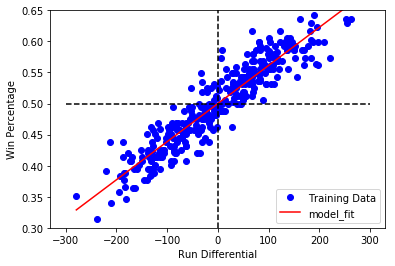

In [59]:
#Graph our data and linear model.
#Set the range of the x-axis from our lowest X value to our highest X value. X is our independant variable, or our input to the model
x_axis = np.array(range(int(np.min(RunDiffTot_train)), int(np.max(RunDiffTot_train)))).reshape(-1, 1)
#Same thing, but for the y-axis. Y is our dependant variable, or the output to the model. By using y=m(x)+b to determine the y-axis, we keep our axis in a reasonable range
y_axis = lin_regr.coef_* x_axis + lin_regr.intercept_

#Now we can plot our training data.
plt.plot(RunDiffTot_train, winPCT_train, 'bo', label='Training Data')
plt.plot(x_axis, y_axis, 'r', label='model_fit')
plt.plot([-300, 300], [0.5, 0.5], "k--") #horizontal line
plt.plot([0, 0], [0.30, 0.65], "k--") #verticle line
plt.ylim([0.30, 0.65])
plt.xlabel("Run Differential")
plt.ylabel("Win Percentage")
plt.legend(loc= "lower right")
plt.show()

In [0]:
#Let's revisit the 2016 dataframe to test the data. I tend to split my data into stratified samples, one for testing and one for training. In this case, we are testing the accuracy of a model built with 11 seasons historical data on the most recent completed season.
#I perceive this to be a bad practice.

In [0]:
#Note to self I suspect this line of code is creating my issues later. Code is fine, I just forgot it is only 2016 data.
log_file = "GL2016.TXT"
df = pd.read_csv(log_file, sep=',', header=None)
processed_df = preprocessing_LR(df)
test_run_diff = processed_df['RunDiff_Tot'].values.reshape([-1, 1])
test_win_pct = processed_df['Win_PCT'].values.reshape([-1, 1])

In [0]:
#Run test set through model. This will give us a prediction (Y value) for our input, run differential
predict_win_pct = lin_regr.predict(test_run_diff)

As a reminder, we are using linear regression to test relationship between run differential and win percentage. We know the actual results of the baseball season. We are running test data through our model, then comparing the predictions made by our model to the actual results. This will give us an idea of how well our model works, if at all.

In [62]:
#We will measure accuracy by averaging the difference between the correct value and our prediction.
mean_error = np.mean(np.abs(predict_win_pct - test_win_pct))
print("Test set Mean Absolute error ", 100.* mean_error, "%")

#How well would the model predict using our training data?
predict_win_pct_train = lin_regr.predict(RunDiffTot_train)
mean_error_train = np.mean(np.abs(predict_win_pct_train- winPCT_train))
print("Train set Mean Absolute error ", 100.* mean_error_train, "%")

Test set Mean Absolute error  2.0162779941678046 %
Train set Mean Absolute error  1.9800854251993616 %


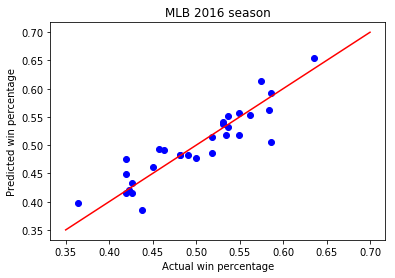

In [63]:
#Let's examine our accuraccy in graph form
# Visualize
plt.plot(test_win_pct, predict_win_pct, 'bo')
plt.plot([0.35, 0.7], [0.35, 0.7], 'r')
plt.xlabel("Actual win percentage")
plt.ylabel("Predicted win percentage")
plt.title("MLB 2016 season")
plt.show()

In [0]:
# The eye test looks decent, but we want to know where our model is producing the largest error. So, which team prediction was off by the most?

In [0]:
#We are creating a new array, which is our error for each team.
lin_regr_error = np.subtract(predict_win_pct, test_win_pct)

In [65]:
np.max(abs(lin_regr_error))

0.08154659641958806

This tells us that our largest error was 8.15%. Which team?

In [66]:
np.argmax(abs(lin_regr_error))

27

In [67]:
processed_df[25:29]

,Team,Runs_by_Visitor,Runs_at_Home,Home_Wins,Home_Games,RunDiff_Home,Runs_as_Visitor,Runs_by_Home,Road_Wins,Away_Games,RunDiff_Away,RunDiff_Tot,Win_Tot,Home_WinPCT,Road_WinPCT,Win_PCT
25,SLN,360.0,355.0,38.0,81,-5.0,424.0,352.0,48.0,81,72.0,67.0,86.0,0.469136,0.592593,0.530864
26,TBA,338.0,314.0,36.0,81,-24.0,358.0,375.0,32.0,81,-17.0,-41.0,68.0,0.444444,0.395062,0.419753
27,TEX,391.0,425.0,53.0,81,34.0,340.0,366.0,42.0,81,-26.0,8.0,95.0,0.654321,0.518519,0.586420
28,TOR,363.0,401.0,46.0,81,38.0,358.0,303.0,43.0,81,55.0,93.0,89.0,0.567901,0.530864,0.549383


In [68]:
processed_df.ix[27]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Team                    TEX
Runs_by_Visitor         391
Runs_at_Home            425
Home_Wins                53
Home_Games               81
RunDiff_Home             34
Runs_as_Visitor         340
Runs_by_Home            366
Road_Wins                42
Away_Games               81
RunDiff_Away            -26
RunDiff_Tot               8
Win_Tot                  95
Home_WinPCT        0.654321
Road_WinPCT        0.518519
Win_PCT             0.58642
Name: 27, dtype: object

In [69]:
processed_df.loc[27]

Team                    TEX
Runs_by_Visitor         391
Runs_at_Home            425
Home_Wins                53
Home_Games               81
RunDiff_Home             34
Runs_as_Visitor         340
Runs_by_Home            366
Road_Wins                42
Away_Games               81
RunDiff_Away            -26
RunDiff_Tot               8
Win_Tot                  95
Home_WinPCT        0.654321
Road_WinPCT        0.518519
Win_PCT             0.58642
Name: 27, dtype: object

In [70]:
predict_win_pct[27]

array([0.50487316])

Our largest error was the Texas Rangers. Our model predicted they would win 50.5% of their games. They overperformed by winning 58.6% of their games. 

# Logistic Regression
We will now attempt to predict categorical output, home team win or loss, based on the number of hits. Dominant class is home team won, so we will attempt to ask a yes no question; Did the Home Team Win? 1 is Yes, 0 is No.

In [0]:
#First, we create an array to hold our training data X(input) is hits specific to the game we are trying to predict.
train_num_hits = np.empty([0, 1]) #Sometimes I name this x_train or even x_train_log_regr
train_win_label = np.empty([0, 1]) #Sometimes I name this y_train or y_train_log_regr

#This should look familiar. We are looping through our individual data files and loading into a dataframe, named df
for y in range(2008, 2018):
  #Let's automate loading data Our file names follow a standard format. That's helpful.
  log_file = "GL" + str(y) + ".TXT"
  
  #Now we load that info in a Dataframe. # I still susspect this code is problematic, and overwriting each year as is loads. .append creates index problem, and reindex errors. .concat has similiar issues.
  #I will need to research at update code when I have time to play.
  df = pd.read_csv(log_file, sep=',', header=None)
  
  #We do not need to process this Dataframe, because our input is given in the data, but we do need to make it easier for humans to read. (note to self, I added column 50 to rename_cols function at this point)
  df = rename_cols(df)
  
  #Create Outcome Column, Y or an answer to the yes no question, did the home team win? This could be written as an if statement in the event we expected to expand this out
  df['Home_win'] = (df['Runs_Home_Team'] > df['Runs_Visiting_Team'])

  #This should look familiar. We are moving our data into 2 seperate arrays. 
  train_num_hits = np.vstack([train_num_hits, df['Hits_Home_Team'].values.reshape([-1, 1])])
  train_win_label = np.vstack([train_win_label, df['Home_win'].values.reshape([-1, 1])])
  

In [97]:
df.shape #I know this code is writting over df with new data, and not appending or concatinating as we would want. Reindex options are not working as expected, and will require further investigation
#Also curious-> I ran the above code with y in range 2008, 2018, then printed df.shape. result was 2430, 162. I noticed error, reran with 2008-2019, and shape is 2431, 162
#This is the clue I needed! The shape is not actually observations, but instead the index max. I will need to research to confirm, But I bet my data set is actually inclusive of all years in loop.

(2430, 162)

columns = {0:'Date', 2:'DOW', 3:'Visiting_Team', 6:'Home_Team', 9:'Runs_Visiting_Team', 10:'Runs_Home_Team', 50:'Hits_Home_Team'}

In [98]:
#Build a Logistic Regression Model. Name the model something intuitive, so that it is easy to compare various models.
log_regr = linear_model.LogisticRegression()

#Fit the model, ravel is used to reshape the array (1-D)
log_regr.fit(train_num_hits, train_win_label.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [99]:
#First glance at results. Logistic regression produces a sigmoid function. Note that we did not run the .predict method
print("Slope = ", "%.4f" % float(log_regr.coef_), "Intercept = ", "%.4f" % float(log_regr.intercept_))

Slope =  0.2548 Intercept =  -2.0145


In [100]:
#Determine the accuracy of the model
log_regr_score_train = log_regr.score(train_num_hits, train_win_label.ravel())
print("Model Accuracy on training data", "%.4f" % float(log_regr_score_train *100.), "%")

Model Accuracy on training data 65.6102 %


In [0]:
#We want to know how this data can be used, meaning, where are the points where number of hits becomes significant. In this case, we will create bins to break the data apart for analysis.
#In theory, a team could have 0 to infinity hits. In practicality, we have reasonable bourdaries. We will limit our analysis to the min and max of our data.

In [0]:
#What is the estimated probability of a home team victory?
#Input data range
hits_range = np.arange(np.min(train_num_hits), np.max(train_num_hits))

prob_est_train_data = np.zeros([len(hits_range), 1]) #create an array of zeros with the shape ((length of our range), 1)

for hits in hits_range:
  index = np.where(train_num_hits == hits)
  if len(index[0]) > 0:
    prob_est_train_data[int(hits - np.min(train_num_hits))] = np.sum(train_win_label[index[0]]) / len(index[0])

In [0]:
#Build a model to estimate the probability of a home team win, using number of hits
prob_est_model = log_regr.predict_proba(train_num_hits)

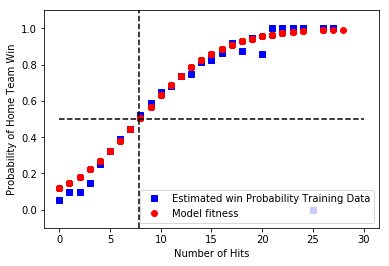

In [104]:
#visualize results
plt.plot(hits_range, prob_est_train_data, 'bs', label="Estimated win Probability Training Data")
plt.plot(train_num_hits, prob_est_model[:, 1], 'ro', label="Model fitness")
plt.plot([0, 30], [0.5, 0.5], "k--")
plt.plot([7.89, 7.89], [-0.1, 1.1], "k--")
plt.ylim([-0.1, 1.1])
plt.legend(loc="lower right")
plt.xlabel("Number of Hits")
plt.ylabel("Probability of Home Team Win")
plt.show()

In [0]:
# Above 22 hits, we see a nearly 100% chance of victory. Below 5 hits, we predict less than 20% chance of victory.

In [0]:
#Next, we will run the model of test data. I would not normally build model with all data and then test on a sample pulled from training set. I typically break data into 2 stratified sets.

In [106]:
df.head(2)

,Date,1,DOW,Visiting_Team,4,5,Home_Team,7,8,Runs_Visiting_Team,Runs_Home_Team,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,Home_win
0,20170402,0,Sun,SFN,NL,1,ARI,NL,1,5,6,53,D,NaN,NaN,NaN,PHO01,49016.0,203,010011101,000003012,34,11,2,1,2,5,0,2,0,5,0,7,2,1,0,0,9,5,6,...,5,parkj002,Jarrett Parker,7,panij002,Joe Panik,4,bumgm001,Madison Bumgarner,1,polla001,A.J. Pollock,8,owinc001,Chris Owings,6,goldp001,Paul Goldschmidt,3,lambj001,Jake Lamb,5,tomay001,Yasmany Tomas,7,drurb001,Brandon Drury,4,perad001,David Peralta,9,mathj001,Jeff Mathis,2,greiz001,Zack Greinke,1,NaN,Y,True
1,20170402,0,Sun,CHN,NL,1,SLN,NL,1,3,4,53,N,NaN,NaN,NaN,STL10,47566.0,213,000000003,001000021,34,8,1,0,1,3,0,0,2,0,0,12,0,0,1,0,6,5,4,...,8,contw001,Willson Contreras,2,lestj001,Jon Lester,1,baezj001,Javier Baez,4,fowld001,Dexter Fowler,8,diaza003,Aledmys Diaz,6,carpm002,Matt Carpenter,3,peraj001,Jhonny Peralta,5,moliy001,Yadier Molina,2,piscs001,Stephen Piscotty,9,gyorj001,Jedd Gyorko,4,gricr001,Randal Grichuk,7,martc006,Carlos Martinez,1,NaN,Y,True


In [107]:
df['Date'].dtype

dtype('int64')

In [127]:
print(df['Date'].min(), df['Date'].max()) #df only contains 2017 season.

2017-04-02 00:00:00 2017-10-01 00:00:00


In [126]:
# Select observations between two datetimes This code was used to troubleshoot. I am saving for reference.
#df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,DOW,Date,Hits_Home_Team,Home_Team,Home_win,Runs_Home_Team,Runs_Visiting_Team,Visiting_Team
2426,20180930.0,0,Sun,CHA,AL,162,MIN,AL,162,4.0,5.0,51,D,NaN,NaN,NaN,MIN04,30144.0,176,200000200,00030200x,32,7,3,0,0,4,1,1,1,3,0,15,0,0,0,0,7,4,5,...,cordr001,Ryan Cordell,8,mauej001,Joe Mauer,3,polaj001,Jorge Polanco,6,cavej001,Jake Cave,8,grosr001,Robbie Grossman,7,garvm001,Mitch Garver,10,keplm001,Max Kepler,9,forsl001,Logan Forsythe,4,astuw001,Willians Astudillo,5,gratj001,Juan Graterol,2,NaN,Y,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2427,20180930.0,0,Sun,TEX,AL,162,SEA,AL,162,1.0,3.0,51,D,NaN,NaN,NaN,SEA03,21146.0,134,000001000,02001000x,29,4,0,0,1,1,0,0,0,0,0,9,0,0,0,0,1,5,3,...,robid003,Drew Robinson,8,hereg002,Guillermo Heredia,8,spand001,Denard Span,7,cruzn002,Nelson Cruz,9,seagk001,Kyle Seager,5,voged001,Daniel Vogelbach,10,healr001,Ryon Healy,3,negrk001,Kristopher Negron,4,freid001,David Freitas,2,romia001,Andrew Romine,6,NaN,Y,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2428,20180930.0,0,Sun,TOR,AL,162,TBA,AL,162,4.0,9.0,51,D,NaN,NaN,NaN,STP01,13313.0,186,001011001,00203031x,35,9,2,1,0,3,0,0,0,3,0,7,1,0,1,0,7,4,9,...,urenr001,Richard Urena,6,smitm007,Mallex Smith,8,phamt001,Tommy Pham,7,wendj002,Joey Wendle,5,cronc002,C.J. Cron,10,loweb001,Brandon Lowe,4,adamw002,Willy Adames,6,meada001,Austin Meadows,9,bauej001,Jake Bauers,3,ciufn001,Nick Ciuffo,2,NaN,Y,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2429,20181001.0,0,Mon,MIL,NL,163,CHN,NL,163,3.0,1.0,54,D,NaN,NaN,NaN,CHI11,38450.0,186,001000020,000010000,34,12,1,0,0,3,2,0,0,0,0,6,1,1,2,0,6,5,1,...,chacj001,Jhoulys Chacin,1,murpd006,Daniel Murphy,4,zobrb001,Ben Zobrist,9,baezj001,Javier Baez,6,rizza001,Anthony Rizzo,3,bryak001,Kris Bryant,5,schwk001,Kyle Schwarber,7,heywj001,Jason Heyward,8,quinj001,Jose Quintana,1,contw001,Willson Contreras,2,NaN,Y,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2430,20181001.0,0,Mon,COL,NL,163,LAN,NL,163,2.0,5.0,51,D,NaN,NaN,NaN,LOS03,47816.0,201,000000002,00022100x,29,4,0,0,2,2,1,0,1,4,0,6,0,1,0,0,6,5,3,...,marqg001,German Marquez,1,pedej001,Joc Pederson,7,turnj001,Justin Turner,5,muncm001,Max Muncy,3,machm001,Manny Machado,6,grany001,Yasmani Grandal,2,bellc002,Cody Bellinger,8,puigy001,Yasiel Puig,9,herne001,Enrique Hernandez,4,buehw001,Walker Buehler,1,NaN,Y,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# Select observations between two datetimes This code was used to troubleshoot. I am saving for reference.
#df[(df['Date'] > '2016-01-01') & (df['Date'] <= '2016-12-31')]

In [0]:
# Select observations between two datetimes This code was used to troubleshoot. I am saving for reference.
#df.shape

In [122]:
df.loc[227] #We have a couple things happening here. 1-We are adding 2017 data into a df that already held 2017 data. Also, as we combine multiple years data, we are maintaining index numbers. 
#This will need to be addressed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,DOW,Date,Hits_Home_Team,Home_Team,Home_win,Runs_Home_Team,Runs_Visiting_Team,Visiting_Team
227,NaN,0,NaN,NaN,NL,15,NaN,NL,16,NaN,NaN,54,N,NaN,NaN,NaN,NYC20,24656.0,194,032000010,013000000,38,10,3,0,1,5,0,0,1,2,0,13,2,0,0,0,8,4,4,...,nolaa001,Aaron Nola,1,granc001,Curtis Granderson,9,cabra002,Asdrubal Cabrera,6,cespy001,Yoenis Cespedes,7,brucj001,Jay Bruce,3,walkn001,Neil Walker,4,confm001,Michael Conforto,8,reyej001,Jose Reyes,5,syndn001,Noah Syndergaard,1,river003,Rene Rivera,2,NaN,Y,Thu,20170420.0,8.0,NYN,False,4.0,6.0,PHI
227,20080417.0,0,Thu,HOU,NL,16,PHI,NL,16,2.0,10.0,51,D,NaN,NaN,NaN,PHI13,33526.0,165,000100001,30120202x,34,8,1,0,2,2,0,0,0,1,0,10,1,0,0,0,6,5,9,...,backb001,Brandon Backe,1,tagus001,So Taguchi,8,dobbg001,Greg Dobbs,5,utlec001,Chase Utley,4,howar001,Ryan Howard,3,burrp001,Pat Burrell,7,jenkg001,Geoff Jenkins,9,costc001,Chris Coste,2,brune001,Eric Bruntlett,6,myerb001,Brett Myers,1,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20090424.0,0,Fri,SFN,NL,15,ARI,NL,16,5.0,1.0,54,N,NaN,NaN,NaN,PHO01,27865.0,181,100101200,000010000,38,12,2,1,2,5,1,0,0,3,0,7,0,0,0,0,10,2,1,...,linct001,Tim Lincecum,1,lopef001,Felipe Lopez,4,byrne001,Eric Byrnes,7,drews001,Stephen Drew,6,reynm001,Mark Reynolds,5,tracc001,Chad Tracy,3,younc004,Chris Young,8,uptoj001,Justin Upton,9,snydc002,Chris Snyder,2,david002,Doug Davis,1,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20100422.0,0,Thu,NYA,AL,15,OAK,AL,17,2.0,4.0,51,D,NaN,NaN,NaN,OAK01,21986.0,127,000011000,30010000x,32,7,1,0,2,2,0,0,0,1,0,3,0,0,2,0,4,1,3,...,gardb001,Brett Gardner,8,davir003,Rajai Davis,8,bartd001,Daric Barton,3,sweer001,Ryan Sweeney,9,suzuk001,Kurt Suzuki,2,fox-j001,Jake Fox,10,kouzk001,Kevin Kouzmanoff,5,rosaa001,Adam Rosales,4,carsm001,Matt Carson,7,pennc001,Cliff Pennington,6,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20110418.0,0,Mon,PIT,NL,16,CIN,NL,16,9.0,3.0,54,N,NaN,NaN,NaN,CIN09,12777.0,182,300510000,010000002,39,15,3,0,0,9,2,0,1,5,0,9,0,0,1,0,11,1,2,...,corrk001,Kevin Correia,1,stubd001,Drew Stubbs,8,rente001,Edgar Renteria,6,vottj001,Joey Votto,3,roles001,Scott Rolen,5,gomej001,Jonny Gomes,7,brucj001,Jay Bruce,9,cairm001,Miguel Cairo,4,hanir001,Ryan Hanigan,2,woodt004,Travis Wood,1,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20120422.0,0,Sun,MIN,AL,16,TBA,AL,16,2.0,6.0,51,D,NaN,NaN,NaN,STP01,26507.0,174,000002000,00212001x,32,5,0,0,0,2,0,0,1,2,0,10,1,0,0,0,6,3,6,...,casia001,Alexi Casilla,4,jennd002,Desmond Jennings,7,zobrb001,Ben Zobrist,9,penac001,Carlos Pena,3,longe001,Evan Longoria,5,keppj001,Jeff Keppinger,10,uptob001,Melvin Upton,8,rodrs002,Sean Rodriguez,6,gimec001,Chris Gimenez,2,johne002,Elliot Johnson,4,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20130419.0,0,Fri,OAK,AL,17,TBA,AL,16,3.0,8.0,51,N,NaN,NaN,NaN,STP01,15115.0,186,200000100,40130000x,35,11,2,0,1,3,0,0,1,3,0,4,0,0,2,0,9,5,8,...,sogae001,Eric Sogard,4,jennd002,Desmond Jennings,8,johnk003,Kelly Johnson,7,zobrb001,Ben Zobrist,9,longe001,Evan Longoria,5,duncs001,Shelley Duncan,10,rodrs002,Sean Rodriguez,3,rober002,Ryan Roberts,4,lobaj001,Jose Lobaton,2,escoy001,Yunel Escobar,6,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20140417.0,0,Thu,ATL,NL,15,PHI,NL,15,0.0,1.0,51,D,NaN,NaN,NaN,PHI13,25750.0,148,0,00000001x,30,4,1,0,0,0,0,0,0,2,0,8,0,1,0,0,5,1,1,...,wooda002,Alex Wood,1,reveb001,Ben Revere,8,rollj001,Jimmy Rollins,6,utlec001,Chase Utley,4,byrdm001,Marlon Byrd,9,maybj001,John Mayberry,3,browd004,Domonic Brown,7,nievw001,Wil Nieves,2,nix-j001,Jayson Nix,5,burna001,A.J. Burnett,1,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,20150423.0,0,Thu,BAL,AL,16,TOR,AL,16,6.0,7.0,51,N,NaN,NaN,NaN,TOR02,18581.0,156,000001104,00331000x,35,8,1,0,2,6,0,0,1,0,0,9,0,0,0,0,3,4,7,...,lavar001,Ryan Lavarnway,2,reyej001,Jose Reyes,6,travd001,Devon Travis,4,donaj001,Josh Donaldson,5,encae

In [0]:
# Select observations between two datetimes
#df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')

In [0]:
#
#df[(df['Date'] > '2016-01-01') & (df['Date'] <= '2016-12-31')]

In [0]:
#Evaluating the model on text data, 2018.
log_file = "GL2016.TXT"
df = pd.read_csv(log_file, sep=',', header=None)

In [0]:
rename_cols(df)

#Create Outcome Column, Y or an answer to the yes no question, did the home team win? This could be written as an if statement in the event we expected to expand this out
df['Home_win'] = (df['Runs_Home_Team'] > df['Runs_Visiting_Team'])

In [0]:
#Build array to hold test data
test_num_hits = df['Hits_Home_Team'].values.reshape([-1, 1])
test_win_label = df['Home_win'].values.reshape([-1, 1])

In [0]:
#MAke predictions on test data
predict_win_label = log_regr.predict(test_num_hits)

In [158]:
#Score model prdicted wins vs actual wins
log_regr_score_test = log_regr.score(test_num_hits, test_win_label.ravel())
print("Model Accuracy on test data", "%.4f" % float(log_regr_score_test *100.), "%")

Model Accuracy on test data 66.7628 %


In [0]:
#Model performance Probability of win based on number of hits
error = np.abs(test_win_label.ravel() - predict_win_label.ravel())
hits_range = np.arange(np.min(test_num_hits), np.max(test_num_hits))
percent_correct = np.zeros([len(hits_range), 1])

for hits in hits_range:
  index_all = np.where(test_num_hits == hits) #all values for # of hits in our range.
  index_correct = np.where((test_num_hits.ravel() == hits) & (error.ravel() == 0))
  percent_correct[int(hits - np.min(test_num_hits))] = len(index_correct[0]) / len(index_all[0])
#Code does not work for 2018 data. Divide by zero error. Later investigation warranted

In [160]:
index_all

(array([ 580, 1012, 1230]), array([0, 0, 0]))

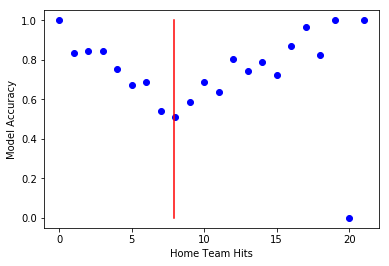

In [161]:
#Visualize Results
plt.plot(hits_range, percent_correct, 'bo')
plt.xlabel("Home Team Hits")
plt.ylabel("Model Accuracy")
mid_point = -1. * float(log_regr.intercept_) / float(log_regr.coef_)
plt.plot([mid_point, mid_point], [0, 1], 'r')
plt.show()

20 Home team hits does not appear in our datset, so the model is 0% accurrate at that x value.